In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import scipy.integrate as integrate

In [13]:
#historical prices for our stocks
tickers = ['CRC','IBE.MC','300750.SZ','SCCO','PUB.PA','KER.PA','CSCO','UNFI','EQNR']
data = yf.download(tickers, start="2020-12-08",end="2022-12-08")
prices = data['Adj Close']
prices.head()

[*********************100%***********************]  9 of 9 completed


,300750.SZ,CRC,CSCO,EQNR,IBE.MC,KER.PA,PUB.PA,SCCO,UNFI
Date,,,,,,,,,
2020-12-08,265.502930,21.484394,41.794132,15.377456,10.348726,565.055420,34.013515,53.985592,18.799999
2020-12-09,265.472992,20.731073,42.095558,15.553780,10.357941,554.815002,34.828732,53.242626,16.110001
2020-12-10,264.295349,21.425694,41.747044,15.711544,10.413233,553.848938,34.742008,52.965134,17.010000
2020-12-11,266.031891,19.566845,41.747044,15.655864,10.367157,554.042114,35.045540,53.493267,15.580000
2020-12-14,265.472992,18.138466,41.671684,15.386732,10.399410,544.960999,35.487843,53.018848,14.940000


In [14]:
#market data over the same period
market_prices = yf.download("MSCI", start="2017-12-08", end="2022-12-08")["Adj Close"]
market_prices.tail()

[*********************100%***********************]  1 of 1 completed


Date
2022-12-01    521.390015
2022-12-02    518.830017
2022-12-05    504.489990
2022-12-06    499.899994
2022-12-07    500.000000
Name: Adj Close, dtype: float64

In [15]:
mcaps = {}
for t in tickers:
    stock = yf.Ticker(t)
    mcaps[t] = stock.info['marketCap']
mcaps

{'CRC': 3040592896,
 'IBE.MC': 66751885312,
 '300750.SZ': 1021726359552,
 'SCCO': 46733774848,
 'PUB.PA': 15721390080,
 'KER.PA': 66450677760,
 'CSCO': 199718617088,
 'UNFI': 2365561600,
 'EQNR': 114820890624}

In [8]:
import pypfopt

In [16]:
from pypfopt import black_litterman, risk_models
from pypfopt import BlackLittermanModel, plotting

S = risk_models.CovarianceShrinkage(prices).ledoit_wolf()
delta = black_litterman.market_implied_risk_aversion(market_prices)
print(delta)
S

2.581287108507394


,300750.SZ,CRC,CSCO,EQNR,IBE.MC,KER.PA,PUB.PA,SCCO,UNFI
300750.SZ,0.258934,0.013236,0.000766,0.004463,-0.005849,0.019571,0.012128,0.037427,0.002763
CRC,0.013236,0.217379,0.023711,0.079638,0.010150,0.023797,0.022553,0.061115,0.071557
CSCO,0.000766,0.023711,0.062898,0.014281,0.011711,0.019704,0.015869,0.020695,0.024858
EQNR,0.004463,0.079638,0.014281,0.127471,-0.000179,0.015039,0.015994,0.059916,0.032798
IBE.MC,-0.005849,0.010150,0.011711,-0.000179,0.056656,0.020610,0.017575,0.001903,-0.000921
KER.PA,0.019571,0.023797,0.019704,0.015039,0.020610,0.098001,0.040701,0.030750,0.015156
PUB.PA,0.012128,0.022553,0.015869,0.015994,0.017575,0.040701,0.078610,0.024233,0.012772
SCCO,0.037427,0.061115,0.020695,0.059916,0.001903,0.030750,0.024233,0.144084,0.037042
UNFI,0.002763,0.071557,0.024858,0.032798,-0.000921,0.015156,0.012772,0.037042,0.299509


In [17]:
market_prior = black_litterman.market_implied_prior_returns(mcaps, delta, S)
market_prior

300750.SZ    0.470196
CRC          0.076591
CSCO         0.050934
EQNR         0.064339
IBE.MC       0.023169
KER.PA       0.079996
PUB.PA       0.059865
SCCO         0.118749
UNFI         0.045786
dtype: float64

In [18]:
viewdict = {
    'CRC': 0.19,
    'IBE.MC': 0.13,
    '300750.SZ': 0.12,
    'SCCO': 0.37,
    'PUB.PA': 0.05,
    'KER.PA': 0.07,
    'CSCO': 0.11,
    'UNFI': 0.48,
    'EQNR': 0.12
}

other_analyst_views = {
    'CRC': 0.42,
    'IBE.MC': 0.10,
    '300750.SZ': 0.41,
    'SCCO': -0.17,
    'PUB.PA': 0.11,
    'KER.PA': 0.16,
    'CSCO': 0.10,
    'UNFI': 0.07,
    'EQNR': 0.04
}

In [19]:
def confidence_calc(stock: str) -> float:
    
    mu = other_analyst_views[stock]
    sigma = (S[stock][stock])**0.5
    
    def normal_pdf(x):
        output = (sigma*(2*3.1415926)**0.5)**(-1)*np.power(2.718281828,-0.5*((x-mu)/sigma)**2)
        return(output)
    
    def normal_cdf(x):
        output = integrate.quad(normal_pdf,-1*np.inf,x)
        return(output)
       
    if viewdict[stock]>other_analyst_views[stock]:
        output = 2*(1-normal_cdf(viewdict[stock])[0])
    else:
        output = 2*normal_cdf(viewdict[stock])[0]
    return(output)
    
confidences = [confidence_calc(stock) for stock in tickers]

confidences

[0.6217939389475913,
 0.8997026806461137,
 0.5687411996321479,
 0.15484988414460066,
 0.830547967597087,
 0.7737351379651417,
 0.9681940975344203,
 0.453755974687827,
 0.8227028841928681]

In [20]:
bl = BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict, omega="idzorek", view_confidences=confidences)

In [21]:
np.diag(bl.omega)

array([0.00661102, 0.0003158 , 0.00981708, 0.0393197 , 0.00080192,
       0.00143293, 0.00010331, 0.01802784, 0.00137354])

In [22]:
omega = bl.omega
bl = BlackLittermanModel(S, pi="market", market_caps=mcaps, risk_aversion=delta,
                        absolute_views=viewdict, omega=omega)
ret_bl = bl.bl_returns()
ret_bl

300750.SZ    0.259272
CRC          0.173664
CSCO         0.108721
EQNR         0.114061
IBE.MC       0.117243
KER.PA       0.078881
PUB.PA       0.055949
SCCO         0.154274
UNFI         0.247307
dtype: float64

In [23]:
rets_df = pd.DataFrame([market_prior, pd.Series(viewdict), pd.Series(other_analyst_views), ret_bl], 
             index=["Prior", "Views", "Other Analysts' Views", "Posterior"]).T
rets_df


,Prior,Views,Other Analysts' Views,Posterior
300750.SZ,0.470196,0.12,0.41,0.259272
CRC,0.076591,0.19,0.42,0.173664
CSCO,0.050934,0.11,0.10,0.108721
EQNR,0.064339,0.12,0.04,0.114061
IBE.MC,0.023169,0.13,0.10,0.117243
KER.PA,0.079996,0.07,0.16,0.078881
PUB.PA,0.059865,0.05,0.11,0.055949
SCCO,0.118749,0.37,-0.17,0.154274
UNFI,0.045786,0.48,0.07,0.247307


<AxesSubplot:>

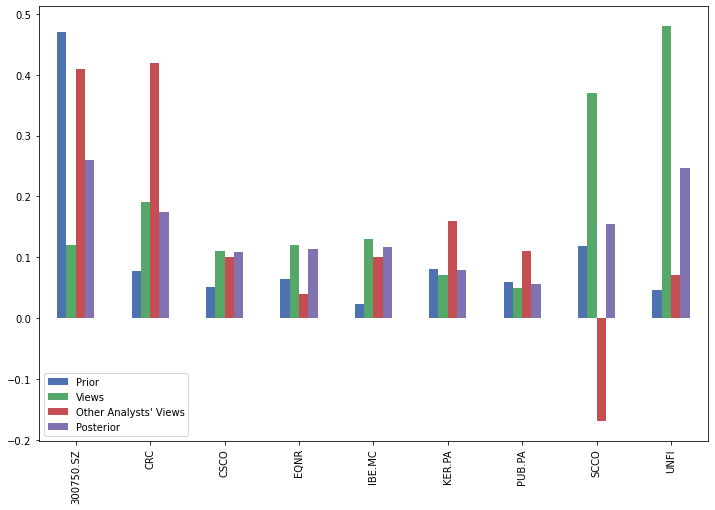

In [24]:
rets_df.plot.bar(figsize=(12,8))

In [28]:
from pypfopt import EfficientFrontier, objective_functions

ef = EfficientFrontier(ret_bl, S)
ef.add_objective(objective_functions.L2_reg)
ef.max_sharpe()
weights = ef.clean_weights()
weights

C:\Users\samdo\anaconda3\lib\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:257: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


OrderedDict([('300750.SZ', 0.22312),
             ('CRC', 0.12343),
             ('CSCO', 0.08741),
             ('EQNR', 0.07713),
             ('IBE.MC', 0.10863),
             ('KER.PA', 0.04651),
             ('PUB.PA', 0.02424),
             ('SCCO', 0.11361),
             ('UNFI', 0.19592)])

<AxesSubplot:ylabel='None'>

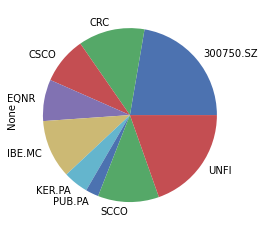

In [29]:
pd.Series(weights).plot.pie()

In [26]:
from pypfopt import DiscreteAllocation

da = DiscreteAllocation(weights, prices.iloc[-1], total_portfolio_value=15000)
alloc, leftover = da.lp_portfolio()
print(f"Leftover: ${leftover:.2f}")
alloc

Leftover: $206.44


C:\Users\samdo\anaconda3\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


{'300750.SZ': 8,
 'CRC': 45,
 'CSCO': 27,
 'EQNR': 32,
 'IBE.MC': 149,
 'KER.PA': 1,
 'PUB.PA': 6,
 'SCCO': 28,
 'UNFI': 74}